# Model building using XGBoost and original CSV data
Based on https://www.kaggle.com/code/wadjihbencheikh/mod-le-1-ms-azure

### This notebook is a copy of the original notebook with the following changes:
- XGBoost is used instead of sklearn's GradientBoostingClassifier. 30x speedup.
- H1st library is used to build the model
- The model is saved in H1st's format

In [1]:
import pandas as pd

telemetry = pd.read_csv('PdM_telemetry.csv')
errors = pd.read_csv('PdM_errors.csv')
maint = pd.read_csv('PdM_maint.csv')
failures = pd.read_csv('PdM_failures.csv')
machines = pd.read_csv('PdM_machines.csv')

In [2]:
maint

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4
...,...,...,...
3281,2015-10-10 06:00:00,100,comp3
3282,2015-10-25 06:00:00,100,comp4
3283,2015-11-09 06:00:00,100,comp4
3284,2015-12-09 06:00:00,100,comp2


In [3]:
# format datetime field which comes in as string
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

print("Total number of telemetry records: %d" % len(telemetry.index))
print(telemetry.head())
telemetry.describe()

Total number of telemetry records: 876100
             datetime  machineID        volt      rotate    pressure   
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935  \
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration  
0  45.087686  
1  43.413973  
2  34.178847  
3  41.122144  
4  25.990511  


,datetime,machineID,volt,rotate,pressure,vibration
count,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,2015-07-02 18:00:00,50.500000,170.777736,446.605119,100.858668,40.385007
min,2015-01-01 06:00:00,1.000000,97.333604,138.432075,51.237106,14.877054
25%,2015-04-02 12:00:00,25.750000,160.304927,412.305714,93.498181,36.777299
50%,2015-07-02 18:00:00,50.500000,170.607338,447.558150,100.425559,40.237247
75%,2015-10-02 00:00:00,75.250000,181.004493,482.176600,107.555231,43.784938
max,2016-01-01 06:00:00,100.000000,255.124717,695.020984,185.951998,76.791072
std,NaN,28.866087,15.509114,52.673886,11.048679,5.370361


Text(0.5, 0, 'Date')

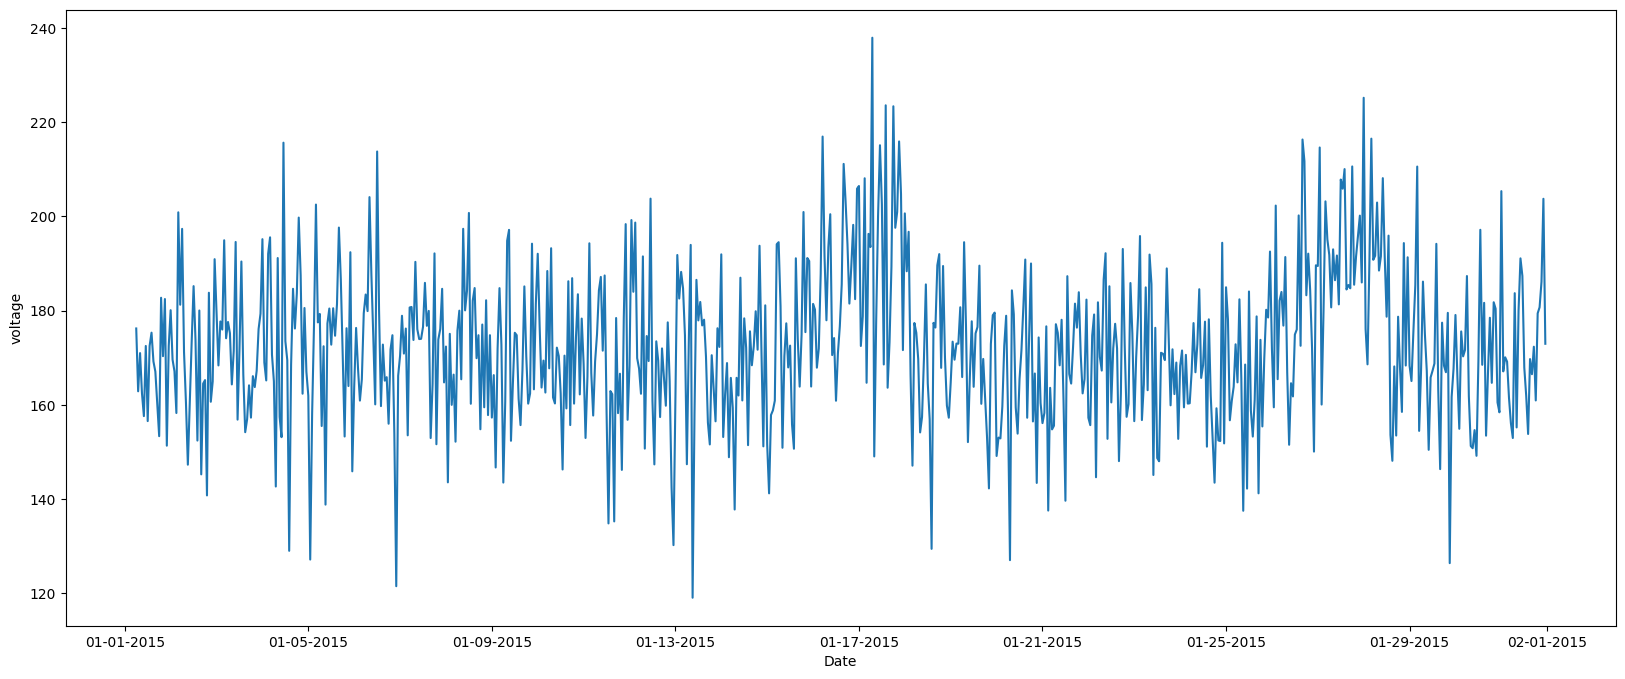

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
# import seaborn as sns

plot_df = telemetry.loc[(telemetry['machineID'] == 1) & 
                        (telemetry['datetime'] > pd.to_datetime('2015-01-01')) & 
                        (telemetry['datetime'] <pd.to_datetime('2015-02-01')),
                        ['datetime','volt']]
# sns.set_style("darkgrid")
plt.figure(figsize=(20, 8))
plt.plot(plot_df['datetime'], plot_df['volt'])
plt.ylabel('voltage')

# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
adf.scaled[1.0] = '%m-%d-%Y'
plt.xlabel('Date')

In [5]:
# format of datetime field which comes in as string
errors['datetime'] = pd.to_datetime(errors['datetime'],format = '%Y-%m-%d %H:%M:%S')
errors['errorID'] = errors['errorID'].astype('category')
print("Total Number of error records: %d" %len(errors.index))
errors.head()

Total Number of error records: 3919


,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


errorID
error1    1010
error2     988
error3     838
error4     727
error5     356
Name: count, dtype: int64

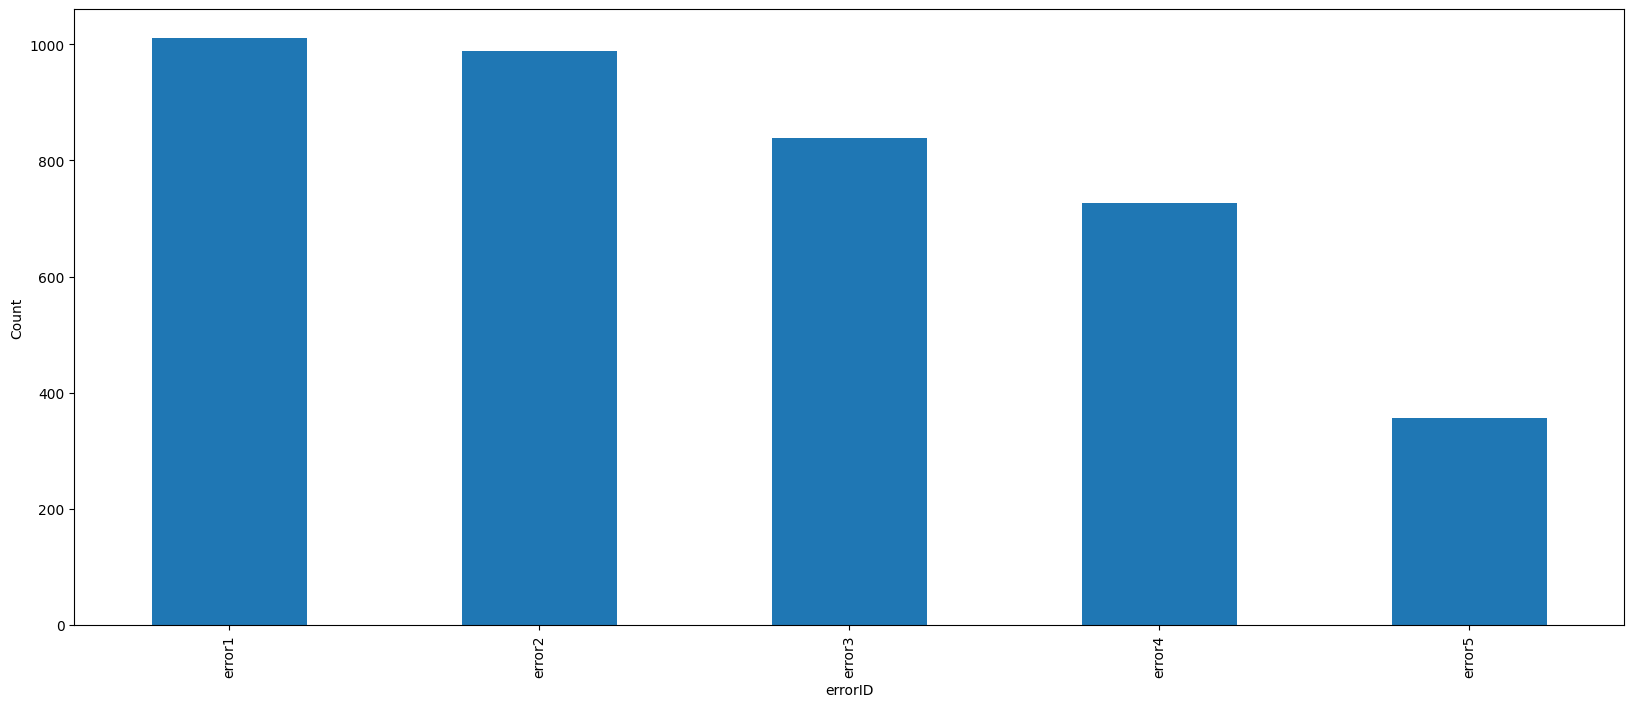

In [6]:
# sns.set_style("darkgrid")
plt.figure(figsize=(20, 8))
errors['errorID'].value_counts().plot(kind='bar')
plt.ylabel('Count')
errors['errorID'].value_counts()

In [7]:
maint['datetime'] = pd.to_datetime(maint['datetime'], format='%Y-%m-%d %H:%M:%S')
maint['comp'] = maint['comp'].astype('category')
print("Total Number of maintenance Records: %d" %len(maint.index))
maint.head()

Total Number of maintenance Records: 3286


,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


comp
comp2    863
comp4    811
comp3    808
comp1    804
Name: count, dtype: int64

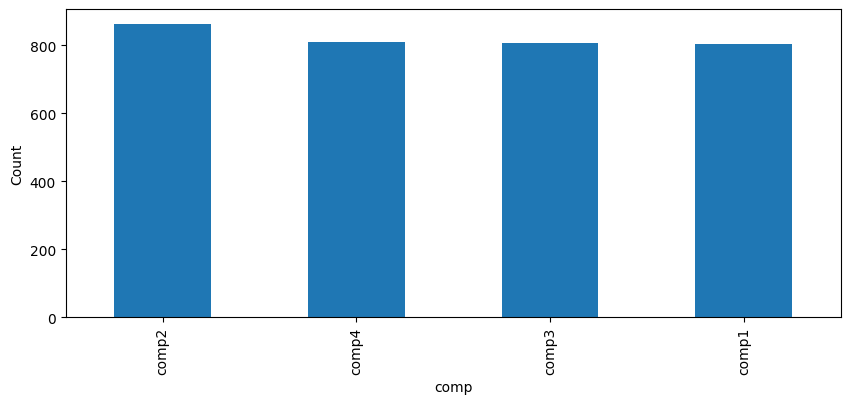

In [8]:
# sns.set_style("darkgrid")
plt.figure(figsize=(10, 4))
maint['comp'].value_counts().plot(kind='bar')
plt.ylabel('Count')
maint['comp'].value_counts()

In [9]:
machines['model'] = machines['model'].astype('category')

print("Total number of machines: %d" % len(machines.index))
machines.head()

Total number of machines: 100


,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


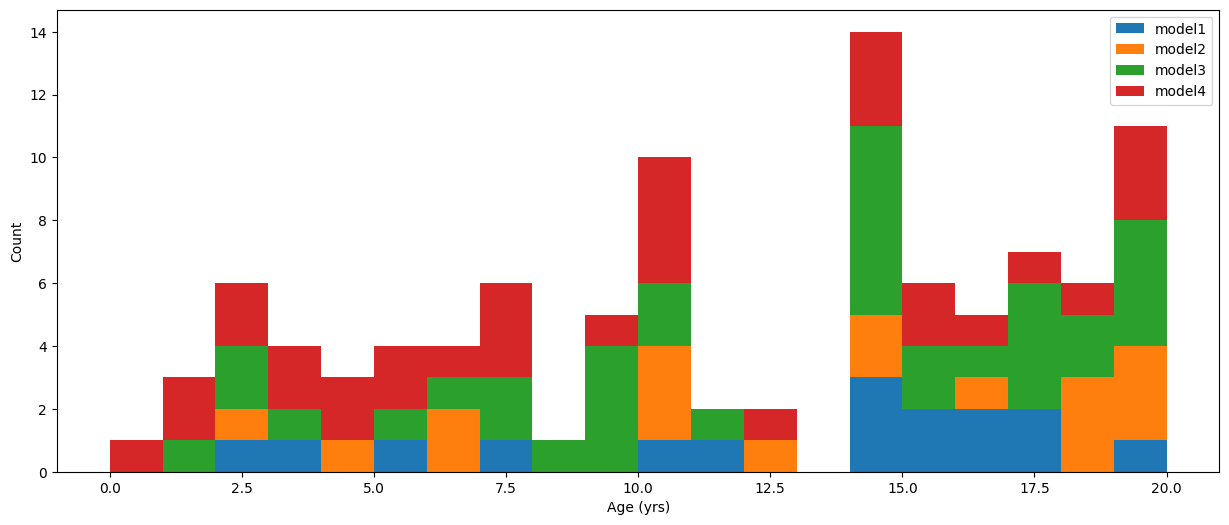

In [10]:
# sns.set_style("darkgrid")
plt.figure(figsize=(15, 6))
_, bins, _ = plt.hist([machines.loc[machines['model'] == 'model1', 'age'],
                       machines.loc[machines['model'] == 'model2', 'age'],
                       machines.loc[machines['model'] == 'model3', 'age'],
                       machines.loc[machines['model'] == 'model4', 'age']],
                       20, stacked=True, label=['model1', 'model2', 'model3', 'model4'])
plt.xlabel('Age (yrs)')
plt.ylabel('Count')
plt.legend()

In [11]:
# format datetime field which comes in as string
failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')

print("Total number of failures: %d" % len(failures.index))
failures.head()

Total number of failures: 761


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


failure
comp2    259
comp1    192
comp4    179
comp3    131
Name: count, dtype: int64

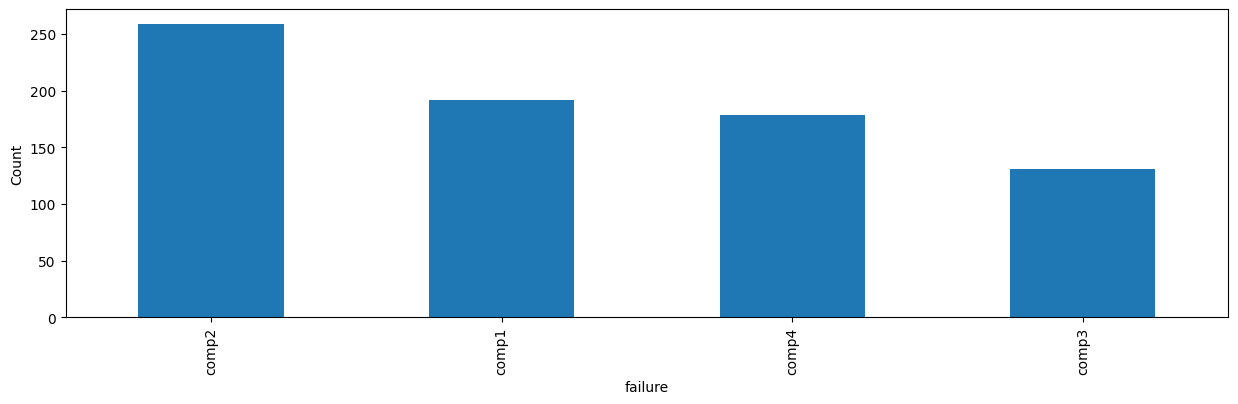

In [12]:
# sns.set_style("darkgrid")
plt.figure(figsize=(15, 4))
failures['failure'].value_counts().plot(kind='bar')
plt.ylabel('Count')
failures['failure'].value_counts()


In [13]:
# Calculate mean values for telemetry features
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').mean().unstack())
telemetry_mean_3h = pd.concat(temp, axis=1)
telemetry_mean_3h.columns = [i + 'mean_3h' for i in fields]
telemetry_mean_3h.reset_index(inplace=True)

# repeat for standard deviation
temp = []
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').std().unstack())
telemetry_sd_3h = pd.concat(temp, axis=1)
telemetry_sd_3h.columns = [i + 'sd_3h' for i in fields]
telemetry_sd_3h.reset_index(inplace=True)

telemetry_mean_3h.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542


In [14]:
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,index='datetime',
                                               columns='machineID',
                                               values=col).rolling(24).mean().resample('3H',
                                                                                closed='left',
                                                                                label='right').first().unstack())
telemetry_mean_24h = pd.concat(temp, axis=1)
telemetry_mean_24h.columns = [i + 'mean_24h' for i in fields]
telemetry_mean_24h.reset_index(inplace=True)
telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h['voltmean_24h'].isnull()]

# repeat for standard deviation
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,index='datetime',
                                               columns='machineID',
                                               values=col).rolling(24).std().resample('3H',
                                                                                closed='left',
                                                                                label='right').first().unstack())
telemetry_sd_24h = pd.concat(temp, axis=1)
telemetry_sd_24h.columns = [i + 'sd_24h' for i in fields]
telemetry_sd_24h = telemetry_sd_24h.loc[-telemetry_sd_24h['voltsd_24h'].isnull()]
telemetry_sd_24h.reset_index(inplace=True)

# Notice that a 24h rolling average is not available at the earliest timepoints
telemetry_mean_24h.head(10)

,machineID,datetime,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h
7,1,2015-01-02 06:00:00,169.733809,445.179865,96.797113,40.385160
8,1,2015-01-02 09:00:00,170.614862,446.364859,96.849785,39.736826
9,1,2015-01-02 12:00:00,169.893965,447.009407,97.715600,39.498374
10,1,2015-01-02 15:00:00,171.243444,444.233563,96.666060,40.229370
11,1,2015-01-02 18:00:00,170.792486,448.440437,95.766838,40.055214
12,1,2015-01-02 21:00:00,170.556674,452.267095,98.065860,40.033247
13,1,2015-01-03 00:00:00,168.460525,451.031783,99.273286,38.903462
14,1,2015-01-03 03:00:00,169.772951,447.502464,99.005946,39.389725
15,1,2015-01-03 06:00:00,170.900562,453.864597,100.877342,38.696225
16,1,2015-01-03 09:00:00,169.533156,454.785072,100.050567,39.449734


In [15]:
# merge columns of feature sets created earlier
telemetry_feat = pd.concat([telemetry_mean_3h,
                            telemetry_sd_3h.iloc[:, 2:6],
                            telemetry_mean_24h.iloc[:, 2:6],
                            telemetry_sd_24h.iloc[:, 2:6]], axis=1).dropna()
telemetry_feat.describe()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
count,290601.000000,290601,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000
mean,50.380935,2015-07-02 22:00:42.478862848,170.774427,446.609386,100.858340,40.383609,13.300173,44.453951,8.885780,4.440575,170.775661,446.609874,100.857574,40.383881,14.919452,49.950788,10.046380,5.002089
min,1.000000,2015-01-02 06:00:00,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,155.812721,266.010419,91.057429,35.060087,6.380619,18.385248,4.145308,2.144863
25%,25.000000,2015-04-03 00:00:00,164.447794,427.564793,96.239534,38.147458,8.028675,26.906319,5.369959,2.684556,168.072275,441.542561,98.669734,39.354077,13.359069,44.669022,8.924165,4.460675
50%,50.000000,2015-07-02 21:00:00,170.432407,448.380260,100.235357,40.145874,12.495542,41.793798,8.345801,4.173704,170.212704,449.206885,100.099533,40.072618,14.854186,49.617459,9.921332,4.958793
75%,75.000000,2015-10-01 15:00:00,176.610017,468.443933,104.406534,42.226898,17.688520,59.092354,11.789358,5.898512,172.462228,456.366349,101.613047,40.833112,16.395372,54.826993,10.980250,5.484430
max,100.000000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,220.782618,499.096975,152.310351,61.932124,27.664538,103.819404,28.654103,12.325783
std,28.798424,NaN,9.498824,33.119738,7.411701,3.475512,6.966389,23.214291,4.656364,2.319989,4.720237,18.070458,4.737293,2.058059,2.261097,7.684305,1.713206,0.799599


In [16]:
telemetry_feat

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
7,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,15.726970,39.648116,11.904700,5.601191
8,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,15.635083,41.828592,11.326412,5.583521
9,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,13.995465,40.843882,11.036546,5.561553
10,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,96.666060,40.229370,13.100364,43.409841,10.972862,6.068674
11,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,95.766838,40.055214,13.808489,43.742304,10.988704,7.286129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291395,100,2015-10-05 09:00:00,188.267556,407.256175,108.931184,36.553233,9.599915,40.722980,1.639521,5.724500,171.826650,441.278667,98.311919,39.196175,16.429023,62.147934,7.475540,5.448962
291396,100,2015-10-05 12:00:00,167.859576,465.992407,107.953155,42.708899,14.190347,92.277799,9.577243,0.735339,174.657123,444.147310,98.520388,38.820190,17.019808,64.730136,8.961444,5.833191
291397,100,2015-10-05 15:00:00,170.348099,434.234744,104.514343,38.607950,10.232598,49.524471,12.445345,2.596743,173.787879,448.842085,100.028549,39.375067,17.096392,64.718132,9.420879,5.738756
291398,100,2015-10-05 18:00:00,152.265370,459.557611,103.536524,40.718426,6.758667,27.051145,12.824247,2.752883,172.496791,442.086577,100.361794,38.943434,15.119775,65.929509,8.836617,6.139142


In [17]:
errors

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4
...,...,...,...
3914,2015-11-21 08:00:00,100,error2
3915,2015-12-04 02:00:00,100,error1
3916,2015-12-08 06:00:00,100,error2
3917,2015-12-08 06:00:00,100,error3


In [18]:
# create a column for each error type
error_count = pd.get_dummies(errors.set_index('datetime')).reset_index()
error_count
error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']
error_count.head(13)

,datetime,machineID,error1,error2,error3,error4,error5
0,2015-01-03 07:00:00,1,True,False,False,False,False
1,2015-01-03 20:00:00,1,False,False,True,False,False
2,2015-01-04 06:00:00,1,False,False,False,False,True
3,2015-01-10 15:00:00,1,False,False,False,True,False
4,2015-01-22 10:00:00,1,False,False,False,True,False
5,2015-01-25 15:00:00,1,False,False,False,True,False
6,2015-01-27 04:00:00,1,True,False,False,False,False
7,2015-03-03 22:00:00,1,False,True,False,False,False
8,2015-03-05 06:00:00,1,True,False,False,False,False
9,2015-03-20 18:00:00,1,True,False,False,False,False


In [19]:
# combine errors for a given machine in a given hour
error_count = error_count.groupby(['machineID','datetime']).sum().reset_index()
error_count.head(13)

,machineID,datetime,error1,error2,error3,error4,error5
0,1,2015-01-03 07:00:00,1,0,0,0,0
1,1,2015-01-03 20:00:00,0,0,1,0,0
2,1,2015-01-04 06:00:00,0,0,0,0,1
3,1,2015-01-10 15:00:00,0,0,0,1,0
4,1,2015-01-22 10:00:00,0,0,0,1,0
5,1,2015-01-25 15:00:00,0,0,0,1,0
6,1,2015-01-27 04:00:00,1,0,0,0,0
7,1,2015-03-03 22:00:00,0,1,0,0,0
8,1,2015-03-05 06:00:00,1,0,0,0,0
9,1,2015-03-20 18:00:00,1,0,0,0,0


In [20]:
error_count = telemetry[['datetime', 'machineID']].merge(error_count, on=['machineID', 'datetime'], how='left').fillna(0.0)
error_count.describe()

,datetime,machineID,error1,error2,error3,error4,error5
count,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,2015-07-02 18:00:00,50.500000,0.001153,0.001128,0.000957,0.000830,0.000406
min,2015-01-01 06:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-04-02 12:00:00,25.750000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015-07-02 18:00:00,50.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2015-10-02 00:00:00,75.250000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2016-01-01 06:00:00,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,28.866087,0.033934,0.033563,0.030913,0.028795,0.020154


In [21]:
error_count[error_count['error3']==1].head(13)

,datetime,machineID,error1,error2,error3,error4,error5
62,2015-01-03 20:00:00,1,0.0,0.0,1.0,0.0,0.0
2592,2015-04-19 06:00:00,1,0.0,1.0,1.0,0.0,0.0
3428,2015-05-24 02:00:00,1,0.0,0.0,1.0,0.0,0.0
3816,2015-06-09 06:00:00,1,0.0,0.0,1.0,0.0,0.0
4156,2015-06-23 10:00:00,1,0.0,0.0,1.0,0.0,0.0
5779,2015-08-30 01:00:00,1,0.0,0.0,1.0,0.0,0.0
6909,2015-10-16 03:00:00,1,0.0,0.0,1.0,0.0,0.0
6912,2015-10-16 06:00:00,1,0.0,1.0,1.0,0.0,0.0
7510,2015-11-10 04:00:00,1,0.0,0.0,1.0,0.0,0.0
10585,2015-03-18 06:00:00,2,1.0,1.0,1.0,0.0,0.0


In [22]:
temp = []
fields = ['error%d' % i for i in range(1,6)]
for col in fields:
    temp.append(pd.pivot_table(error_count,
                                               index='datetime',
                                               columns='machineID',
                                               values=col).rolling(24).sum().resample('3H',
                                                                             closed='left',
                                                                             label='right').first().unstack())
error_count = pd.concat(temp, axis=1)
error_count.columns = [i + 'count' for i in fields]
error_count.reset_index(inplace=True)
error_count = error_count.dropna()
error_count.describe()

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
count,291400.00000,291400,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000
mean,50.50000,2015-07-03 07:30:00,0.027649,0.027069,0.022907,0.019904,0.009753
min,1.00000,2015-01-02 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,2015-04-03 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.50000,2015-07-03 07:30:00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.25000,2015-10-02 09:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.00000,2016-01-01 09:00:00,2.000000,2.000000,2.000000,2.000000,2.000000
std,28.86612,NaN,0.166273,0.164429,0.151453,0.140820,0.098797


In [23]:
error_count

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
7,1,2015-01-02 06:00:00,0.0,0.0,0.0,0.0,0.0
8,1,2015-01-02 09:00:00,0.0,0.0,0.0,0.0,0.0
9,1,2015-01-02 12:00:00,0.0,0.0,0.0,0.0,0.0
10,1,2015-01-02 15:00:00,0.0,0.0,0.0,0.0,0.0
11,1,2015-01-02 18:00:00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
292095,100,2015-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0
292096,100,2016-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0
292097,100,2016-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0
292098,100,2016-01-01 06:00:00,0.0,0.0,0.0,0.0,0.0


This is the feature that I did not like. As you can see, most recent component change may occured beforestart of the data.
**remove dates in 2014 (may have NaN or future component change dates)** is a very hacky way to deal with this problem. SO, while this is an impactful feature, I decided not to use it.
In my model, I will simply count all component changes that occured within the data available to us.

In [24]:
import numpy as np

# create a column for each error type
comp_rep = pd.get_dummies(maint.set_index('datetime')).reset_index()
comp_rep.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']

# combine repairs for a given machine in a given hour
comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

# add timepoints where no components were replaced
comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                      on=['datetime', 'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])

components = ['comp1', 'comp2', 'comp3', 'comp4']
for comp in components:
    # convert indicator to most recent date of component change
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']
    
    # forward-fill the most-recent date of component change
    comp_rep[comp] = comp_rep[comp].fillna(method='ffill')

# remove dates in 2014 (may have NaN or future component change dates)    
comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]

# replace dates of most recent component change with days since most recent component change
for comp in components:
    comp_rep[comp] = (comp_rep['datetime'] - comp_rep[comp]) / np.timedelta64(1, 'D')

# comp_rep = comp_rep.dropna().loc[(comp_rep['comp1'] < 0) | (comp_rep['comp2'] < 0) | (comp_rep['comp3'] < 0) | (comp_rep['comp4'] < 0)]
    
comp_rep.describe()

,datetime,machineID,comp1,comp2,comp3,comp4
count,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,2015-07-02 18:00:00,50.500000,53.525185,51.540806,52.725962,53.834191
min,2015-01-01 06:00:00,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-04-02 12:00:00,25.750000,13.291667,12.125000,13.125000,13.000000
50%,2015-07-02 18:00:00,50.500000,32.791667,29.666667,32.291667,32.500000
75%,2015-10-02 00:00:00,75.250000,68.708333,66.541667,67.333333,70.458333
max,2016-01-01 06:00:00,100.000000,491.958333,348.958333,370.958333,394.958333
std,NaN,28.866087,62.491679,59.269254,58.873114,59.707978


In [25]:
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,19.000000,214.000000,154.000000,169.000000
1,2015-01-01 07:00:00,1,19.041667,214.041667,154.041667,169.041667
2,2015-01-01 08:00:00,1,19.083333,214.083333,154.083333,169.083333
3,2015-01-01 09:00:00,1,19.125000,214.125000,154.125000,169.125000
4,2015-01-01 10:00:00,1,19.166667,214.166667,154.166667,169.166667


In [26]:
comp_rep[comp_rep['comp4']<0].head()

,datetime,machineID,comp1,comp2,comp3,comp4


In [27]:
telemetry_feat

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
7,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,15.726970,39.648116,11.904700,5.601191
8,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,15.635083,41.828592,11.326412,5.583521
9,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,13.995465,40.843882,11.036546,5.561553
10,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,96.666060,40.229370,13.100364,43.409841,10.972862,6.068674
11,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,95.766838,40.055214,13.808489,43.742304,10.988704,7.286129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291395,100,2015-10-05 09:00:00,188.267556,407.256175,108.931184,36.553233,9.599915,40.722980,1.639521,5.724500,171.826650,441.278667,98.311919,39.196175,16.429023,62.147934,7.475540,5.448962
291396,100,2015-10-05 12:00:00,167.859576,465.992407,107.953155,42.708899,14.190347,92.277799,9.577243,0.735339,174.657123,444.147310,98.520388,38.820190,17.019808,64.730136,8.961444,5.833191
291397,100,2015-10-05 15:00:00,170.348099,434.234744,104.514343,38.607950,10.232598,49.524471,12.445345,2.596743,173.787879,448.842085,100.028549,39.375067,17.096392,64.718132,9.420879,5.738756
291398,100,2015-10-05 18:00:00,152.265370,459.557611,103.536524,40.718426,6.758667,27.051145,12.824247,2.752883,172.496791,442.086577,100.361794,38.943434,15.119775,65.929509,8.836617,6.139142


In [28]:
final_feat = telemetry_feat.merge(error_count, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(comp_rep, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(machines, on=['machineID'], how='left')

print(final_feat)
final_feat.describe()

        machineID            datetime  voltmean_3h  rotatemean_3h   
0               1 2015-01-02 06:00:00   180.133784     440.608320  \
1               1 2015-01-02 09:00:00   176.364293     439.349655   
2               1 2015-01-02 12:00:00   160.384568     424.385316   
3               1 2015-01-02 15:00:00   170.472461     442.933997   
4               1 2015-01-02 18:00:00   163.263806     468.937558   
...           ...                 ...          ...            ...   
290596        100 2015-10-05 09:00:00   188.267556     407.256175   
290597        100 2015-10-05 12:00:00   167.859576     465.992407   
290598        100 2015-10-05 15:00:00   170.348099     434.234744   
290599        100 2015-10-05 18:00:00   152.265370     459.557611   
290600        100 2015-10-05 21:00:00   162.887965     481.415205   

        pressuremean_3h  vibrationmean_3h  voltsd_3h  rotatesd_3h   
0             94.137969         41.551544  21.322735    48.770512  \
1            101.553209         3

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,age
count,290601.000000,290601,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,...,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000
mean,50.380935,2015-07-02 22:00:42.478862848,170.774427,446.609386,100.858340,40.383609,13.300173,44.453951,8.885780,4.440575,...,0.027560,0.027058,0.022846,0.019955,0.009780,53.382610,51.256589,52.536687,53.679601,11.345226
min,1.000000,2015-01-02 06:00:00,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,2015-04-03 00:00:00,164.447794,427.564793,96.239534,38.147458,8.028675,26.906319,5.369959,2.684556,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.250000,12.000000,13.000000,12.875000,7.000000
50%,50.000000,2015-07-02 21:00:00,170.432407,448.380260,100.235357,40.145874,12.495542,41.793798,8.345801,4.173704,...,0.000000,0.000000,0.000000,0.000000,0.000000,32.625000,29.500000,32.125000,32.375000,12.000000
75%,75.000000,2015-10-01 15:00:00,176.610017,468.443933,104.406534,42.226898,17.688520,59.092354,11.789358,5.898512,...,0.000000,0.000000,0.000000,0.000000,0.000000,68.500000,65.875000,67.125000,70.250000,16.000000
max,100.000000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,...,2.000000,2.000000,2.000000,2.000000,2.000000,491.875000,348.875000,370.875000,394.875000,20.000000
std,28.798424,NaN,9.498824,33.119738,7.411701,3.475512,6.966389,23.214291,4.656364,2.319989,...,0.166026,0.164401,0.151266,0.140998,0.098931,62.478424,59.156008,58.822946,59.658975,5.826345


In [29]:
labeled_features = final_feat.merge(failures, on=['datetime', 'machineID'], how='left')
labeled_features = labeled_features.fillna(method='bfill', limit=7) # fill backward up to 24h
labeled_features['failure'] = labeled_features['failure'].cat.add_categories(
    'none')
labeled_features['failure'] = labeled_features['failure'].fillna("none")
# labeled_features
labeled_features['failure'].value_counts()

failure
none     284993
comp2      1977
comp1      1464
comp4      1240
comp3       968
Name: count, dtype: int64

In [30]:
labeled_features.columns

Index(['machineID', 'datetime', 'voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count', 'comp1', 'comp2', 'comp3',
       'comp4', 'model', 'age', 'failure'],
      dtype='object')

In [31]:
labeled_features.loc[labeled_features['failure'] == 'comp4'][:16]

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
17,1,2015-01-04 09:00:00,166.281848,453.787824,106.187582,51.990080,24.276228,23.621315,11.176731,3.394073,...,1.0,0.0,1.0,22.125,217.125,157.125,172.125,model3,18,comp4
18,1,2015-01-04 12:00:00,175.412103,445.450581,100.887363,54.251534,34.918687,11.001625,10.580336,2.921501,...,1.0,0.0,1.0,22.250,217.250,157.250,172.250,model3,18,comp4
19,1,2015-01-04 15:00:00,157.347716,451.882075,101.289380,48.602686,24.617739,28.950883,9.966729,2.356486,...,1.0,0.0,1.0,22.375,217.375,157.375,172.375,model3,18,comp4
20,1,2015-01-04 18:00:00,176.450550,446.033068,84.521555,47.638836,8.071400,76.511343,2.636879,4.108621,...,1.0,0.0,1.0,22.500,217.500,157.500,172.500,model3,18,comp4
21,1,2015-01-04 21:00:00,190.325814,422.692565,107.393234,49.552856,8.390777,7.176553,4.262645,7.598552,...,1.0,0.0,1.0,22.625,217.625,157.625,172.625,model3,18,comp4
22,1,2015-01-05 00:00:00,169.985134,458.929418,91.494362,54.882021,9.451483,12.052752,3.685906,6.621183,...,0.0,0.0,1.0,22.750,217.750,157.750,172.750,model3,18,comp4
23,1,2015-01-05 03:00:00,149.082619,412.180336,93.509785,54.386079,19.075952,30.715081,3.090266,6.530610,...,0.0,0.0,1.0,22.875,217.875,157.875,172.875,model3,18,comp4
24,1,2015-01-05 06:00:00,185.782709,439.531288,99.413660,51.558082,14.495664,45.663743,4.289212,7.330397,...,0.0,0.0,1.0,0.000,218.000,158.000,0.000,model3,18,comp4
1337,1,2015-06-18 09:00:00,169.324639,453.923471,101.313249,53.092274,28.155693,42.557599,7.688674,2.488851,...,0.0,0.0,1.0,89.125,29.125,14.125,134.125,model3,18,comp4
1338,1,2015-06-18 12:00:00,190.691297,441.577271,97.192512,44.025425,6.296827,47.271008,7.577957,4.648336,...,0.0,0.0,1.0,89.250,29.250,14.250,134.250,model3,18,comp4


In [32]:
# Let's look at the distribution of the labels
labeled_features['failure'].value_counts()

failure
none     284993
comp2      1977
comp1      1464
comp4      1240
comp3       968
Name: count, dtype: int64

In [33]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

from h1st.model.ml_model import MLModel
from h1st.model.ml_modeler import MLModeler

class XGBClassifierModel(MLModel):
    def predict(self, data: dict) -> dict:
        """Run model inference on incoming data and return predictions in a
           dictionary.
           Input data should have key 'X' with data values
        """
        labelEncoder, model = self.base_model
        predictions = labelEncoder.inverse_transform(model.predict(data['X']))
        return {'predictions': predictions}


class XGBClassifierModeler(MLModeler):
    def __init__(self):
        super().__init__()
        self.model_class = XGBClassifierModel

    def train_base_model(self, prepared_data):
        """trains and returns the base ML model that will be wrapped by the
           H1st MyMLModel
        """
        X, y = prepared_data['X_train'], prepared_data['y_train']
        labelEncoder = LabelEncoder()
        y = labelEncoder.fit_transform(y)
        model = XGBClassifier(random_state=42)
        model.fit(X, y)
        return labelEncoder, model

    def load_data(self):
        """Implementing this function is optional, alternatively data can
           be passed directly to the build_model function. If implemented,
           the build_model function can be run without any input.
        """
        pass

    def  evaluate_model(self, data: dict, ml_model: MLModel) -> dict:
        """Optional, if implemented then metrics will be attached to the
           trained model created by the build_model method, and can be
           persisted along with the model
        """
        x_test = {'X': data['X_test']}
        y_test = data['y_test']
        y_pred = ml_model.predict(x_test)['predictions']
        accuracy = accuracy_score(y_test, y_pred)
        cf = confusion_matrix(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        f1 = 2 * precision * recall / (precision + recall)
        return {'accuracy_score': accuracy,
                'confusion_matrix': cf,
                'recall': recall,
                'precision': precision,
                'f1': f1}

/Users/mike/Documents/Interviews/Aitomatic/predictive_maintenance_model/.conda/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/mike/Documents/Interviews/Aitomatic/predictive_maintenance_model/.conda/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprec

In [34]:
class PredictiveMaintananceModeler(XGBClassifierModeler):
    def __init__(self, train_test_split_ratio=0.3):
        super().__init__()
        self.model_class = XGBClassifierModel
        self.train_test_split_ratio = train_test_split_ratio
    def load_data(self):
        """One-hot encode categorical features and split data into train and test sets
        """
        X = pd.get_dummies(labeled_features.drop(['machineID', 'failure'], axis=1)) # we need 'datetime', for splitting data
        y = labeled_features['failure']
        
        # split data into train and test sets by 'datetime' column at self.train_test_split_ratio
        dates = X['datetime'].unique()
        split_index = int(len(dates) * self.train_test_split_ratio)
        split_date = dates[split_index]
        X_train, X_test = X[X['datetime'] < split_date], X[X['datetime'] >= split_date]
        y_train, y_test = y[X['datetime'] < split_date], y[X['datetime'] >= split_date]
        X_train, X_test = X_train.drop(['datetime'], axis=1), X_test.drop(['datetime'], axis=1)

        prepared_data = {'X_train': X_train, 'y_train': y_train,
                        'X_test': X_test, 'y_test': y_test}
        return prepared_data

In [35]:
my_modeler = PredictiveMaintananceModeler(train_test_split_ratio=0.5)
my_model = my_modeler.build_model()

accuracy = my_model.metrics['accuracy_score'] * 100
print(f"Accuracy (test): {accuracy:.1f}%")
precision_score = my_model.metrics['precision'] * 100
print(f"Precision (test): {precision_score:.1f}%")
recall_score = my_model.metrics['recall'] * 100
print(f"Recall (test): {recall_score:.1f}%")
f1_score = my_model.metrics['f1'] * 100
print(f"F1 (test): {f1_score:.1f}%")

Accuracy (test): 99.9%
Precision (test): 99.9%
Recall (test): 99.9%
F1 (test): 99.9%
